# Artificial Intelligence
# 464
# Project #4

## Before You Begin...
00. We're using a Jupyter Notebook environment (tutorial available here: https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html),
01. Read the entire notebook before beginning your work, and
02.  Check the submission deadline on Gradescope.


## General Directions for this Assignment
00. Output format should be exactly as requested,
01. Functions should do only one thing,
02. Keep functions to 20 lines or less (empty lines are fine, there's leeway, but don't blatantly ignore this),
03. Add docstring to all functions,


## Before You Submit...
00. Re-read the general instructions provided above, and
01. Hit "Kernel"->"Restart & Run All". The first cell that is run should show [1], the second should show [2], and so on...
02. Submit your notebook (as .ipynb, not PDF) using Gradescope, and
03.  Do not submit any other files.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import networkx as nx
from copy import deepcopy
import random

You might need to do a install to work with networkx

```
pip install networkx
```

In [2]:
class Node():
  def __init__(self, name, idx, coordinates, adjacent_nodes):
    '''
    Initialize a Node object

    Args:
      name (string): label associated with node
      idx (int): index associated with node
      coordinates (Tuple[int, int]): coordinates of node
      adjacent_notes (int[]): list of nodes adjacent to current

    Returns:
      None
    '''
    self.name = name                  # string: node name
    self.index = idx                  # int: index in graph order
    self.adjacent = adjacent_nodes    # int[]: adjacent node indices
    self.coords = coordinates         # Tuple[int, int]: coordinates
    self.color = None                 # int | None: index of color

In [3]:
def init_graph(constraint_graph):
  '''
  Initialize a graph with Node objects based on contraint graph structure

  Args:
    constraint_graph (Dict[nodes: string[], edges: Tuple[int, int], coordinates: Tuple[int, int]]):
      dictionary representing nodes, edges, and node coordinates for a graph

  Returns:
    Node[] - list of nodes in the graph
  '''
  # create adjacency lists
  adjacent_nodes = [set() for i in range(len(constraint_graph['nodes']))]
  for i, j in constraint_graph['edges']:
    adjacent_nodes[i].add(j)
    adjacent_nodes[j].add(i)

  # initialize nodes
  graph = []
  for i in range(len(constraint_graph['nodes'])):
    graph.append(Node(constraint_graph['nodes'][i], i, constraint_graph['coordinates'][i], adjacent_nodes[i]))

  return graph


## Part 1: Constraint Satisfaction

## Map Coloring

It turns out that any division of a plane into contiguous regions can be colored such that no two adjacent regions are the same color by using only four colors (see [Four Color Theorem](http://en.wikipedia.org/wiki/Four_color_theorem), for more details) This **Constraint Satisfaction Problem** can be viewed as a constraint graph, where variables are nodes and no adjacent nodes can be of the same color.


Our first constraint graph is the dictionary `connecticut_graph` with three keys: 1) "nodes," which is a ordered list of strings that represent the nodes; 2) "edges," which indicates with tuples which nodes are adjacent; and 3) the "coordinates" key helps NetworkX make cartoons.

In [4]:
connecticut_graph = { "nodes": ["Fairfield", "Litchfield", "New Haven", "Hartford", "Middlesex", "Tolland", "New London", "Windham"],
                "edges": [(0,1), (0,2), (1,2), (1,3), (2,3), (2,4), (3,4), (3,5), (3,6), (4,6), (5,6), (5,7), (6,7)],
                "coordinates": [( 46, 52), ( 65,142), (104, 77), (123,142), (147, 85), (162,140), (197, 94), (217,146)]}
print(connecticut_graph)

{'nodes': ['Fairfield', 'Litchfield', 'New Haven', 'Hartford', 'Middlesex', 'Tolland', 'New London', 'Windham'], 'edges': [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (3, 6), (4, 6), (5, 6), (5, 7), (6, 7)], 'coordinates': [(46, 52), (65, 142), (104, 77), (123, 142), (147, 85), (162, 140), (197, 94), (217, 146)]}


In [5]:
def get_valid_colors(node, graph, color_list):
  """
  Get remaining valid colors for a given node

  Args:
    node (Node): node to get valid color set for
    graph (Node[]): list of nodes representing constraint graph
    color_list (string[]): list of valid color options

  Returns:
    Set[string] - set of available colors
  """
  available = set(color_list)
  for a in node.adjacent:
    if graph[a].color is not None:
      available.discard(color_list[graph[a].color])

  return available

In [6]:
def forward_check(node, graph, color_list):
  """
  Check validity of current graph to ensure node assignment still has possible solution

  Args:
    node (Node): node to validate assignment for
    graph (Node[]): list of nodes representing constraint graph
    color_list (string[]): list of valid color options

  Returns:
    boolean - if the given assignment still has a possible solution
  """
  # check that no adjacent node has no remaining options
  for n in node.adjacent:
    avail = get_valid_colors(graph[n], graph, color_list)
    if len(avail) == 0: return False
  
  return True


In [7]:
def mrv(graph, color_list):
  """
  Find the node in the graph with the minimum remaining values

  Args:
    graph (Node[]): list of nodes representing constraint graph
    color_list (string[]): list of valid color options

  Returns:
    int - index of node with minimum remaining values
  """
  remaining = []

  # calculate number of remaining colors for each node
  for node in graph:
    # max out remaining if node already assigned
    if node.color is not None:
      remaining.append(len(color_list))
      continue

    avail = get_valid_colors(node, graph, color_list)
    remaining.append(len(avail))

  # return idx of first node with min remaining vals
  return remaining.index(min(remaining))


In [8]:
def lcv(node, graph, color_list, valid_options):
  """
  Get least constraining color option for given node

  Args:
    node (Node): node to find lcv for
    graph (Node[]): list of nodes representing constraint graph
    color_list (string[]): list of valid color options
    valid_options (Set[string]): set of valid color options for node

  Returns:
    int[] - indexes of valid color options
  """
  # get unassigned nodes in graph
  unassigned = [graph[adj] for adj in node.adjacent if graph[adj].color is None]
  # get indexes of valid color options
  valid_options = [i for i in range(len(color_list)) if i in valid_options]
  # tracker for num remaining options for given color assignment
  lcvOptions = [0] * len(color_list)
  

  # tally up number of options for each color
  for i in valid_options:
    # get remaining options for unassigned adjacent nodes
    for n in unassigned:
      # count remaining options for unassigned nodes
      if n.color is None:
        available = get_valid_colors(n, graph, color_list)
        available.discard(color_list[i])
        if len(available) == 0: break
        lcvOptions[i] += len(available)

  # sort options by least to most constrained
  valid_options.sort(key=lambda x: lcvOptions[x], reverse=True)
  return valid_options



In [9]:
def backtrack(idx, graph, color_list):
  """
  CSP recursive backtracking process

  Args:
    idx (int): index of node to test assignments for
    graph (Node[]): list of nodes representing constraint graph
    color_list (string[]): list of valid color options

  Returns:
    Tuple[int, string] | None - solution set of node, color pairs or None if no solution
  """
  node = graph[idx]
  # base case: already assigned, return solution
  if node.color is not None:
    return [(n.index, color_list[n.color]) for n in graph]

  # if node has no valid colors, no solution
  avail_colors = get_valid_colors(node, graph, color_list)
  avail_colors = [i for i in range(len(color_list)) if color_list[i] in avail_colors]
  if len(avail_colors) == 0: return None
  
  # by order of least constrained colors, test color for solution
  lcvs = lcv(node, graph, color_list, avail_colors)
  for color in lcvs:
    node.color = color

    # forward check to ensure solution is still possible
    if not forward_check(node, graph, color_list):
      continue

    # solution possible --> recursively test colors for most restricted
    m = mrv(graph, color_list)
    sol = backtrack(m, graph, color_list)
    if sol is not None:
      return sol
    
  # No solution --> clear assignment
  node.color = None
  return None

In [10]:
def color_map(constraint_graph, color_list, trace=False):
    """
    This function colors a map provided as a constraint graph (dict keys: nodes, edges, and coordinate)
    The inputs are the constraint graph and a list of colors. 
    Implementation should feature: 
    1) Backtracking, 2) Forward Checking, 3) variables picked using MRV, and 4) Values picked using LCV. 
    Each feature should be its own helper function.  
    The trace is a flag that when set to True, prints out statements that state what the algorithm
    is currently doing (in terms of the four features)
    Return a list of (node name, assigned color) tuples, where 
    the ordering matches the original ordering of nodes in the constraint_graph. 
    For example, if we had `["A", "B"]` as nodes and `["Yellow", "Green"]` as colors, 
    your function might return `[("A", "Yellow"), ("B", "Green")]`
    If the CSP cannot find a solution, `None` is returned.
    """
    # Fix. Everything is colored red right now. 
    # With your implementation, if a solution can't be found, it should return `None`.
    # Add features: 
    # 1) Backtracking, 
    # 2) Forward Checking, 
    # 3) Variables picked using MRV, and 
    # 4) Values picked using LCV 
    # Features should be helper functions
    graph = init_graph(constraint_graph)
    solution = backtrack(0, graph, color_list)
    return solution
    
    # return [(n, "red") for n in constraint_graph["nodes"]]

In [11]:
def test_coloring(constraint_graph, solution):
    """
    This function tests the solution resulting from `color_map`. 
    Adjacent nodes in the solution cannot be of the same color.
    constraint_graph is the dict with keys: nodes, edges, and coordinates.
    solution is a list of (node name, assigned color) tuples
    Returns a warning statement if there's a violation
    """
    nodes = constraint_graph[ "nodes"]
    edges = constraint_graph["edges"]
    for start, end in edges:
        try:
            assert solution[start][1] != solution[end][1]
        except AssertionError:
            print(f"{nodes[start]} and {nodes[end]} are adjacent but have the same color.")

In [12]:
def draw_map(title, constraint_graph, size, solution=None):
    """
    This function uses Networkx to draw the `constraint_graph` (dict keys: nodes, edges, and coordinate) 
    Nodes are colored using `solution`, a list of (node name, assigned color) tuples
    title is the title for the cartoon
    size is in inches wide x inches tall, so (8,10) results in 8"x10" rendering (depends on monitor)
    """
    
    def as_dictionary(a_list):
        dct = {}
        for i, e in enumerate(a_list):
            dct[i] = e
        return dct
    
    G = nx.Graph()
    
    labels = as_dictionary(constraint_graph["nodes"])
    pos = as_dictionary(constraint_graph["coordinates"])
    
    # create a List of Nodes as indices to match the "edges" entry.
    nodes = [n for n in range(0, len(constraint_graph["nodes"]))]

    if solution:
        colors = [c for n, c in solution]
    else:
        colors = ['red' for c in range(0,len(constraint_graph["nodes"]))]

    G.add_nodes_from(nodes)
    G.add_edges_from(constraint_graph["edges"])

    plt.figure(figsize=size, dpi=100)
    plt.title(title)
    nx.draw(G, node_color = colors, with_labels = True, labels = labels, pos = pos)
    
#    plt.savefig(name + ".png")

## Problem 1. Color Connecticut with Four Colors

In [13]:
connecticut_solution = color_map(connecticut_graph, ["red", "blue", "green", "yellow"], trace=True)

## Test Connecticut Solution

In [14]:
if connecticut_solution:
    test_coloring(connecticut_graph, connecticut_solution)

## Draw Connecticut Cartoon

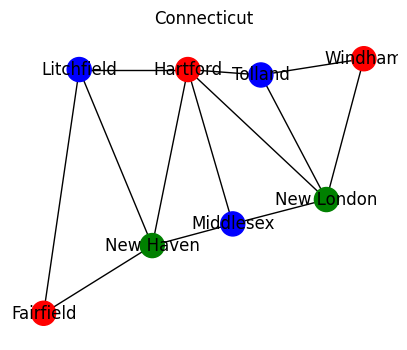

In [15]:
if connecticut_solution:
    draw_map("Connecticut", connecticut_graph, (5,4), connecticut_solution)

## Problem 2. Color Connecticut with Three Colors

In [16]:
connecticut_solution = color_map(connecticut_graph, ["red", "blue", "green"], trace=True)

## Test Connecticut Solution

In [17]:
if connecticut_solution:
    test_coloring(connecticut_graph, connecticut_solution)

## Draw Connecticut Cartoon

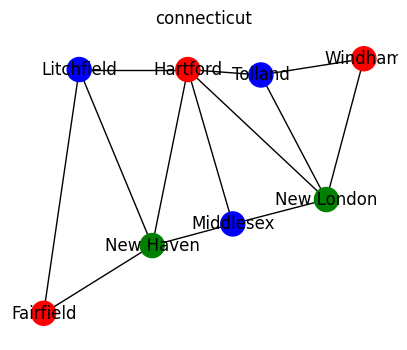

In [18]:
if connecticut_solution:
    draw_map("connecticut", connecticut_graph, (5,4), connecticut_solution)

## Problem 3. Color Europe with Four Colors

In [46]:
europe_graph = {
    "nodes":  ["Iceland", "Ireland", "United Kingdom", "Portugal", "Spain",
                 "France", "Belgium", "Netherlands", "Luxembourg", "Germany",
                 "Denmark", "Norway", "Sweden", "Finland", "Estonia",
                 "Latvia", "Lithuania", "Poland", "Czech Republic", "Austria",
                 "Liechtenstein", "Switzerland", "Italy", "Malta", "Greece",
                 "Albania", "Macedonia", "Kosovo", "Montenegro", "Bosnia Herzegovina",
                 "Serbia", "Croatia", "Slovenia", "Hungary", "Slovakia",
                 "Belarus", "Ukraine", "Moldova", "Romania", "Bulgaria",
                 "Cyprus", "Turkey", "Georgia", "Armenia", "Azerbaijan",
                 "Russia" ], 
    "edges": [(0,1), (0,2), (1,2), (2,5), (2,6), (2,7), (2,11), (3,4),
                 (4,5), (4,22), (5,6), (5,8), (5,9), (5,21), (5,22),(6,7),
                 (6,8), (6,9), (7,9), (8,9), (9,10), (9,12), (9,17), (9,18),
                 (9,19), (9,21), (10,11), (10,12), (10,17), (11,12), (11,13), (11,45), 
                 (12,13), (12,14), (12,15), (12,17), (13,14), (13,45), (14,15),
                 (14,45), (15,16), (15,35), (15,45), (16,17), (16,35), (17,18),
                 (17,34), (17,35), (17,36), (18,19), (18,34), (19,20), (19,21), 
                 (19,22), (19,32), (19,33), (19,34), (20,21), (21,22), (22,23),
                 (22,24), (22,25), (22,28), (22,29), (22,31), (22,32), (24,25),
                 (24,26), (24,39), (24,40), (24,41), (25,26), (25,27), (25,28),
                 (26,27), (26,30), (26,39), (27,28), (27,30), (28,29), (28,30),
                 (29,30), (29,31), (30,31), (30,33), (30,38), (30,39), (31,32),
                 (31,33), (32,33), (33,34), (33,36), (33,38), (34,36), (35,36),
                 (35,45), (36,37), (36,38), (36,45), (37,38), (38,39), (39,41),
                 (40,41), (41,42), (41,43), (41,44), (42,43), (42,44), (42,45),
                 (43,44), (44,45)],
    "coordinates": [( 18,147), ( 48, 83), ( 64, 90), ( 47, 28), ( 63, 34),
                   ( 78, 55), ( 82, 74), ( 84, 80), ( 82, 69), (100, 78),
                   ( 94, 97), (110,162), (116,144), (143,149), (140,111),
                   (137,102), (136, 95), (122, 78), (110, 67), (112, 60),
                   ( 98, 59), ( 93, 55), (102, 35), (108, 14), (130, 22),
                   (125, 32), (128, 37), (127, 40), (122, 42), (118, 47),
                   (127, 48), (116, 53), (111, 54), (122, 57), (124, 65),
                   (146, 87), (158, 65), (148, 57), (138, 54), (137, 41),
                   (160, 13), (168, 29), (189, 39), (194, 32), (202, 33),
                   (191,118)]}
print(europe_graph)

{'nodes': ['Iceland', 'Ireland', 'United Kingdom', 'Portugal', 'Spain', 'France', 'Belgium', 'Netherlands', 'Luxembourg', 'Germany', 'Denmark', 'Norway', 'Sweden', 'Finland', 'Estonia', 'Latvia', 'Lithuania', 'Poland', 'Czech Republic', 'Austria', 'Liechtenstein', 'Switzerland', 'Italy', 'Malta', 'Greece', 'Albania', 'Macedonia', 'Kosovo', 'Montenegro', 'Bosnia Herzegovina', 'Serbia', 'Croatia', 'Slovenia', 'Hungary', 'Slovakia', 'Belarus', 'Ukraine', 'Moldova', 'Romania', 'Bulgaria', 'Cyprus', 'Turkey', 'Georgia', 'Armenia', 'Azerbaijan', 'Russia'], 'edges': [(0, 1), (0, 2), (1, 2), (2, 5), (2, 6), (2, 7), (2, 11), (3, 4), (4, 5), (4, 22), (5, 6), (5, 8), (5, 9), (5, 21), (5, 22), (6, 7), (6, 8), (6, 9), (7, 9), (8, 9), (9, 10), (9, 12), (9, 17), (9, 18), (9, 19), (9, 21), (10, 11), (10, 12), (10, 17), (11, 12), (11, 13), (11, 45), (12, 13), (12, 14), (12, 15), (12, 17), (13, 14), (13, 45), (14, 15), (14, 45), (15, 16), (15, 35), (15, 45), (16, 17), (16, 35), (17, 18), (17, 34), (17, 

In [20]:
europe_solution = color_map(europe_graph, ["red", "blue", "green", "yellow"], trace=False)

## Test Europe Solution

In [21]:
if europe_solution:
    test_coloring(europe_graph, europe_solution)

## Draw Europe Cartoon

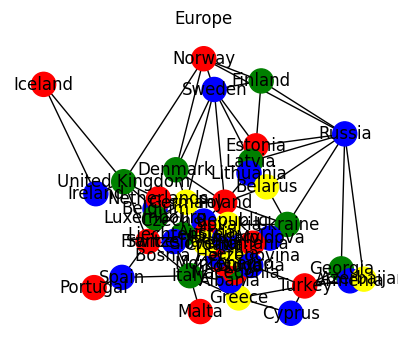

In [22]:
if europe_solution:
    draw_map("Europe", europe_graph, (5,4), europe_solution)

## Problem 4. Color Europe with Three Colors

In [23]:
europe_solution = color_map(europe_graph, ["red", "blue", "green"], trace=False)

## Test Europe Solution

In [24]:
if europe_solution:
    test_coloring(europe_graph, europe_solution)

## Draw Europe Cartoon

In [25]:
if europe_solution:
    draw_map("Europe", europe_graph, (5,4), europe_solution)

## Part 2: Genetic Algorithms
Genetic algorithms can approximate the same constraint satisfaction solutions that we programmed algorithmically. We have provided some code to help you get started.

Color Europe from using four colors: ["red", "blue", "green", "yellow"]. 

Your implementation should:

* Start with a random population of candidates
* Run for a defined number of generations
* Select parents (implement tournament)
* Apply Crossover
* Apply Mutation
* Apply Culling (remove a fraction of the lowest fitness individuals from the new population)

You'll need encoders/decoders to switch between genomes and phenomes. 

You'll need an approproate fitness function. 

You'll need a suite of tunable parameters (number of generations, crossover rate, location, mutation rate, location, value, culling rate, and so on).

Every ten generations, print out the generation number, the fitness, genotype, and phenotype of the best individual in the population for the specific generation. Return the best individual of the entire run (in the same format).

Feel free to port over helper functions from your solution from Part #1

In [26]:
def initialize_population(constraint_graph, color_list, population_size):
    """
    Initialize a graph with Node objects based on contraint graph structure

    Args:
        constraint_graph (Dict[nodes: string[], edges: Tuple[int, int], coordinates: Tuple[int, int]]):
        dictionary representing nodes, edges, and node coordinates for a graph
        color_list (string[]): list of valid color options

    Returns:
        Node[][] - randomly generated population representing constraint graphs
    """
    population = []
    for i in range(population_size):
        graph = init_graph(constraint_graph)
        for node in graph:
            node.color = random.randint(0, len(color_list) - 1)

        population.append(graph)
    
    return population

In [39]:
def fitness(graph):
    """
    Compute the fitness of a given graph

    Args:
        graph (Node[]): list of nodes representing constraint graph

    Returns:
        int - computed fitness score
    """
    fitnessScore = 0
    for node in graph:
        for adjacent in node.adjacent:
            if graph[adjacent].color != node.color:
                fitnessScore += 1
            else:
                fitnessScore -= 1

    return fitnessScore

In [ ]:
def tournament_selection(population, size): # TODO Add parameters
    """
    Selects the best individual from a subset of the population using a tournament-style selection 
    process. This helps maintain a balance between exploration and exploitation by favoring individuals 
    with higher fitness while still allowing for some randomness.
    
    Args:
        population (Node[][]): list of colored graphs
        size (int): tournament size

    Returns:
        Node[] - graph with best fitness
    """
    # randomly select population of given size
    random.shuffle(population)
    tournament_set = population[:size]
    return max(tournament_set, key=lambda g: fitness(g))

In [ ]:
def crossover(graph1, graph2, threshold): # TODO Add parameters
    """
    Performs crossover (recombination) between two parent individuals to produce a child. 
    The crossover is applied with a probability determined by crossover_rate, where a 
    higher rate means a higher chance of crossover occurring.
    
    Args:
        graph1 (Node[]): graph to include in crossover
        graph2 (Node[]): graph to include in crossover
        threshold (float): likelihood of applying crossover

    Returns:
        Node[] | None: result of crossover, or none if did not occur
    """
    rand = random.random()
    if rand > threshold:
        # crossover at random point
        r = random.randint(0, len(graph1) - 1)
        return [deepcopy(n) for n in graph1[:r]] + [deepcopy(n) for n in graph2[r:]]
    
    return None

In [ ]:
def mutate(graph, color_list, threshold): # TODO Add parameters
    """
    Mutates an individual by randomly changing the color of one of its nodes, based on 
    a given mutation rate. The mutation ensures that the new color is different from the current one.
    
    Args:
        graph (Node[]): graph to apply mutation to
        color_list (string[]): list of valid colors
        threshold: likelihood of mutation

    Returns:
        boolean - indicate if mutation was applied
    """
    rand = random.random()
    if rand > threshold:
        # mutate color ensuring difference
        node = random.choice(graph)
        color_options = [i for i in range(len(color_list)) if i != node.color]
        node.color = random.choice(color_options)

        return True
    
    return False

In [ ]:
def cull_population(population, proportion): # TODO Add parameters
    """
    Reduces the population size by selecting the best individuals based on their fitness scores. 
    The individuals with the lowest fitness are culled, and only a specified proportion of the population is retained.
    
    Args:
        population (Node[][]): list of graphs in population
        proportion (float): proportion of population to keep

    Returns:
        Node[][] - new population without lowest fitness members
    """
    # TODO docstring
    # Your code here
    # calculate fitness for entire population
    # take top x percent based on given proportion
    fitnessScores = []
    for i in range(len(population)):
        score = fitness(population[i])
        fitnessScores.append((score, i))

    fitnessScores.sort(reverse=True)
    nIndividuals = int(len(population) * proportion)
    return [population[fitnessScores[i][1]] for i in range(nIndividuals)]


In [32]:
def report_fitness(generation, best_fitness, best_individual, color_list, constraint_graph):
    """
    Reports the fitness of the best individual in the current generation.

    * **generation** int: The current generation number.
    * **best_fitness** float: The fitness score of the best individual.
    * **best_individual** list: The genotype of the best individual, represented as a list of color indices.
    * **color_list** list: A list of available colors. Each color is represented as a string (e.g., "red", "blue").
    * **constraint_graph** dict: A dictionary representing the constraint graph, including nodes and their neighbors (edges).
    """
    print(f"Generation {generation}: Best Fitness {best_fitness}, "
            f"Genotype {best_individual}, "
            f"Phenotype {[color_list[gene] for gene in best_individual]}")
    
    solution = [(constraint_graph["nodes"][i], color_list[best_individual[i]]) for i in range(len(best_individual))]
    draw_map(f"Generation {generation}", constraint_graph, size=(10, 8), solution=solution)

In [33]:
def genetic_algorithm(color_list, constraint_graph, hyperparameters, trace=False):
    """
    Executes a genetic algorithm to solve a graph coloring problem by evolving a population of individuals over multiple generations. Each individual represents a potential solution, where nodes of the graph are assigned colors. The goal is to minimize conflicts between neighboring nodes sharing the same color.

    * **color_list** list: A list of available colors. Each color is represented as a string (e.g., "red", "blue").
    * **constraint_graph** dict: A dictionary representing the constraint graph, including nodes and their neighbors (edges).
    * **hyperparameters** dict: A dictionary containing hyperparameters for the genetic algorithm.
    * **trace** bool: If True, prints detailed information about the evolution process.

    **returns** list: The best individual found after NUM_GENERATIONS generations, represented as a list of color indices corresponding to each node in the graph. Additionally, the algorithm prints the best fitness, genotype, and phenotype at various points during the execution.
    """
    population = initialize_population(constraint_graph, color_list, hyperparameters["POPULATION_SIZE"]) # TODO initialize_population 
    # neighbor_set = ... # TODO create neighbor set from constraint_graph
    best_individual = None
    best_fitness = float('-inf')

    for i in range(hyperparameters["NUM_GENERATIONS"]):
        # TODO Evaluate fitness of the population
        fitnessScores = [fitness(graph) for graph in population]
        maxFitIdx = fitnessScores.index(max(fitnessScores))
        best_individual = [node.color for node in population[maxFitIdx]]
        best_fitness = fitnessScores[maxFitIdx]

        # Report the best individual and fitness found so far
        if trace and i % 10 == 0:
            report_fitness(i, best_fitness, best_individual, color_list, constraint_graph)

        # TODO Create new population through selection, crossover, mutation, and culling
        nextGen = []
        for j in range(hyperparameters["POPULATION_SIZE"]):
            parent1 = tournament_selection(population, hyperparameters["TOURNAMENT_SIZE"])
            parent2 = tournament_selection(population, hyperparameters["TOURNAMENT_SIZE"])
            child = crossover(parent1, parent2, hyperparameters["CROSSOVER_RATE"])
            if child is not None:
                mutate(child, color_list, hyperparameters["MUTATION_RATE"])
                nextGen.append(child)

        cull_population(nextGen, hyperparameters["CULLING_RATE"])

        population = nextGen

    # Final report of the best solution found
    if trace:
        print("Final report:")
        report_fitness(hyperparameters["NUM_GENERATIONS"], best_fitness, best_individual, color_list, constraint_graph)
    
    return best_individual, best_fitness


In [34]:
def color_map_genetic(constraint_graph, color_list, hyperparameters, trace=False):
    """
    Executes a genetic algorithm to solve a graph coloring problem by evolving a population of individuals over multiple generations. Each individual represents a potential solution, where nodes of the graph are assigned colors. The goal is to minimize conflicts between neighboring nodes sharing the same color.

    * **constraint_graph** dict: A dictionary representing the constraint graph, including nodes and their neighbors (edges).
    * **color_list** list: A list of available colors. Each color is represented as a string (e.g., "red", "blue").
    * **hyperparameters** dict: A dictionary containing hyperparameters for the genetic algorithm.
    * **trace** bool: If True, prints detailed information about the evolution process.

    **returns** list: The best individual found after NUM_GENERATIONS generations, represented as a list of color indices corresponding to each node in the graph.
    """
    best_individual, best_fitness = genetic_algorithm(color_list, constraint_graph, hyperparameters, trace)
    if best_fitness == len(constraint_graph["edges"]) * 2: # TODO Check if best_fitness indicates a valid solution
        return [(constraint_graph["nodes"][i], color_list[best_individual[i]]) for i in range(len(best_individual))]
    else:
        print("No valid solution found.")
        return None

#### Hyperparameters:
- **NUM_GENERATIONS** int: The number of generations for the genetic algorithm to evolve through. The higher this number, the longer the algorithm runs.
- **POPULATION_SIZE** int: The size of the population at each generation. A larger population can explore the solution space more thoroughly but increases computational cost.
- **CROSSOVER_RATE** float: The probability that two selected parents will undergo crossover. A higher rate means more offspring will be produced by recombination.
- **MUTATION_RATE** float: The probability that a mutation will occur in a given individual. This introduces genetic diversity and helps avoid local optima.
- **CULLING_RATE** float: The proportion of the population that will be culled (removed) at the end of each generation. A higher culling rate means only the fittest individuals are retained.
- **TOURNAMENT_SIZE** int: The number of individuals selected for tournament selection. Larger values give stronger individuals a higher chance of being selected.

In [49]:
# TODO: Define the parameters for the genetic algorithm
num_generations: int   = 100
population_size: int   = 500
crossover_rate : float = 0.8
mutation_rate  : float = 0.5
culling_rate   : float = 0.8
tournament_size: int   = 200

hyperparameters = {
    "NUM_GENERATIONS": num_generations,
    "POPULATION_SIZE": population_size,
    "CROSSOVER_RATE": crossover_rate,
    "MUTATION_RATE": mutation_rate,
    "CULLING_RATE": culling_rate,
    "TOURNAMENT_SIZE": tournament_size
}

Generation 0: Best Fitness 154, Genotype [1, 1, 0, 1, 3, 3, 1, 2, 0, 0, 3, 1, 0, 3, 3, 1, 0, 1, 3, 2, 3, 0, 0, 3, 0, 1, 3, 2, 2, 0, 0, 1, 0, 2, 1, 3, 2, 0, 3, 2, 1, 3, 3, 2, 1, 2], Phenotype ['blue', 'blue', 'red', 'blue', 'yellow', 'yellow', 'blue', 'green', 'red', 'red', 'yellow', 'blue', 'red', 'yellow', 'yellow', 'blue', 'red', 'blue', 'yellow', 'green', 'yellow', 'red', 'red', 'yellow', 'red', 'blue', 'yellow', 'green', 'green', 'red', 'red', 'blue', 'red', 'green', 'blue', 'yellow', 'green', 'red', 'yellow', 'green', 'blue', 'yellow', 'yellow', 'green', 'blue', 'green']
Generation 10: Best Fitness 206, Genotype [2, 0, 1, 2, 0, 1, 3, 0, 0, 2, 0, 2, 1, 3, 0, 3, 2, 1, 3, 1, 2, 0, 3, 2, 0, 2, 1, 3, 0, 3, 2, 1, 2, 3, 2, 0, 2, 3, 0, 3, 3, 1, 3, 2, 0, 1], Phenotype ['green', 'red', 'blue', 'green', 'red', 'blue', 'yellow', 'red', 'red', 'green', 'red', 'green', 'blue', 'yellow', 'red', 'yellow', 'green', 'blue', 'yellow', 'blue', 'green', 'red', 'yellow', 'green', 'red', 'green', 'blue'

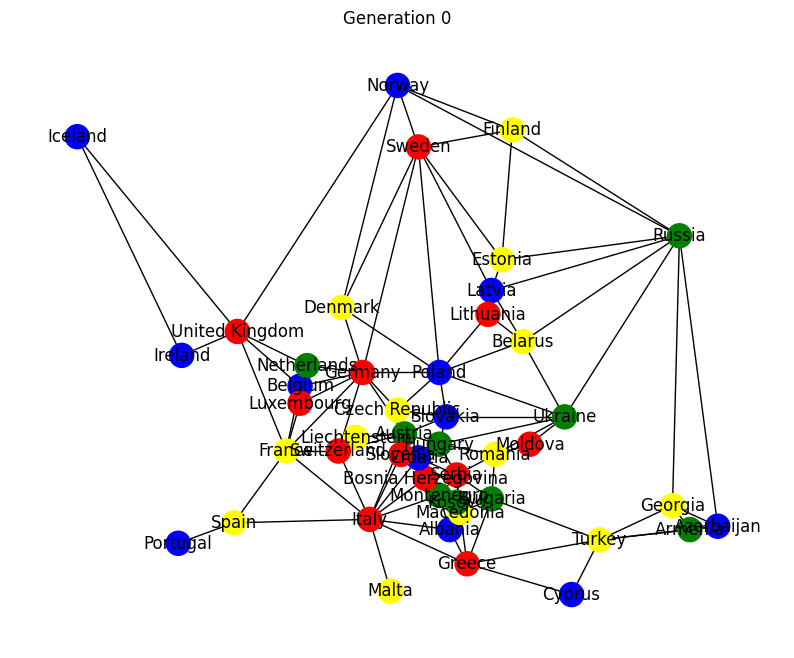

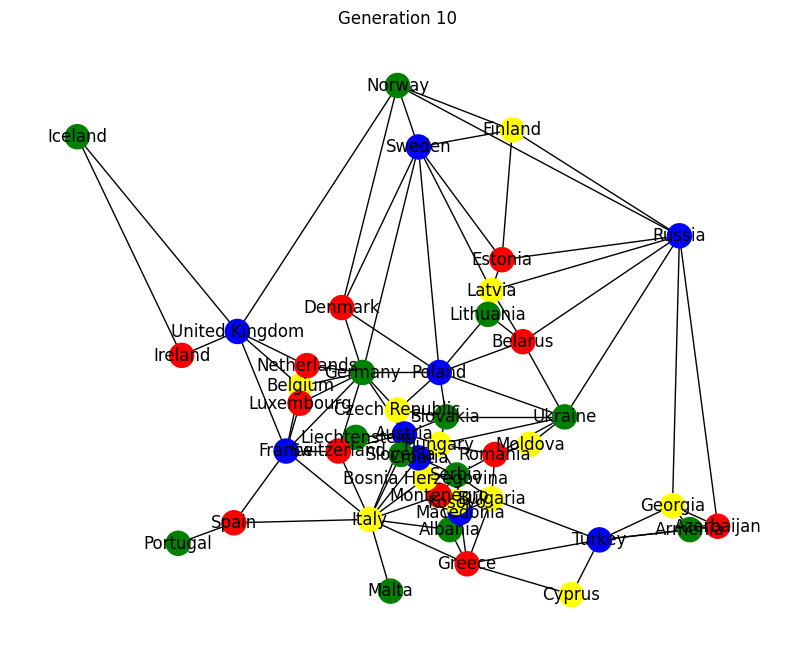

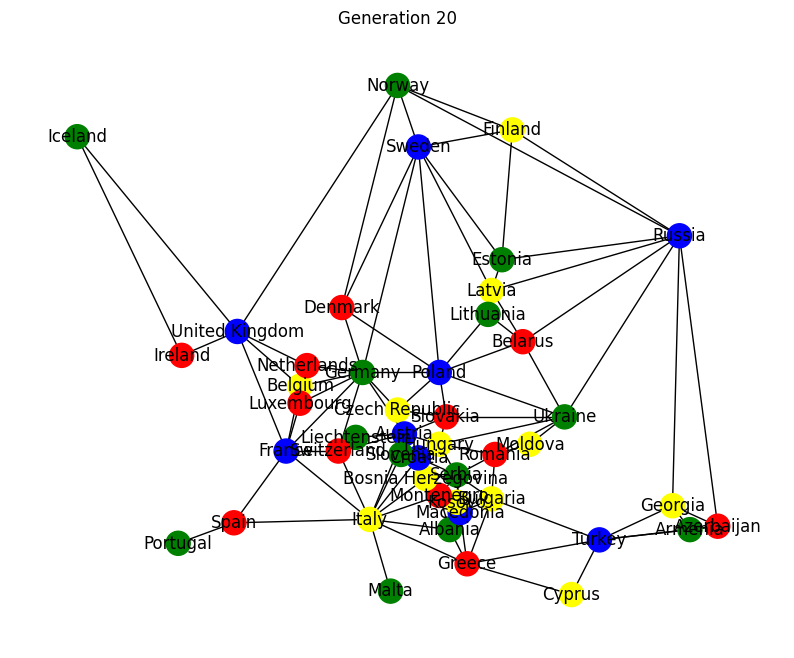

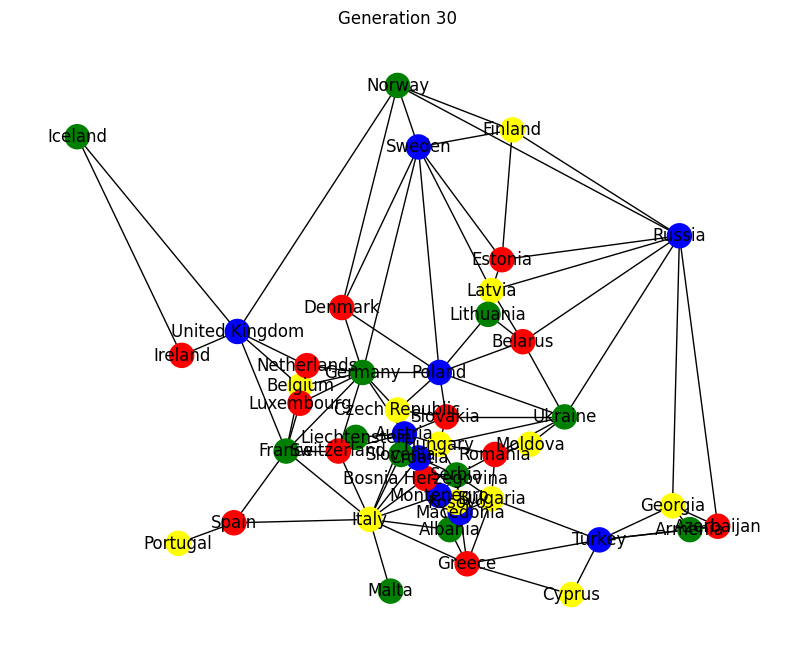

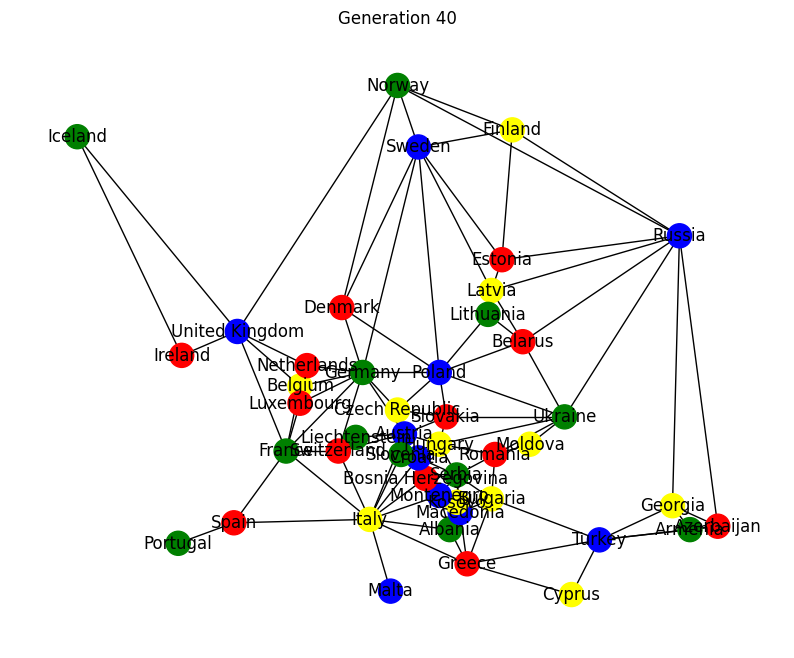

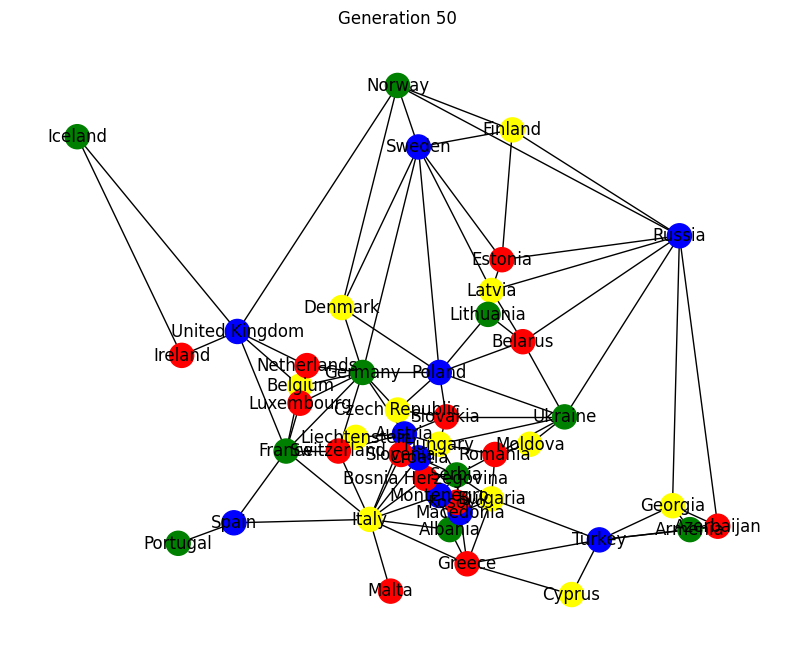

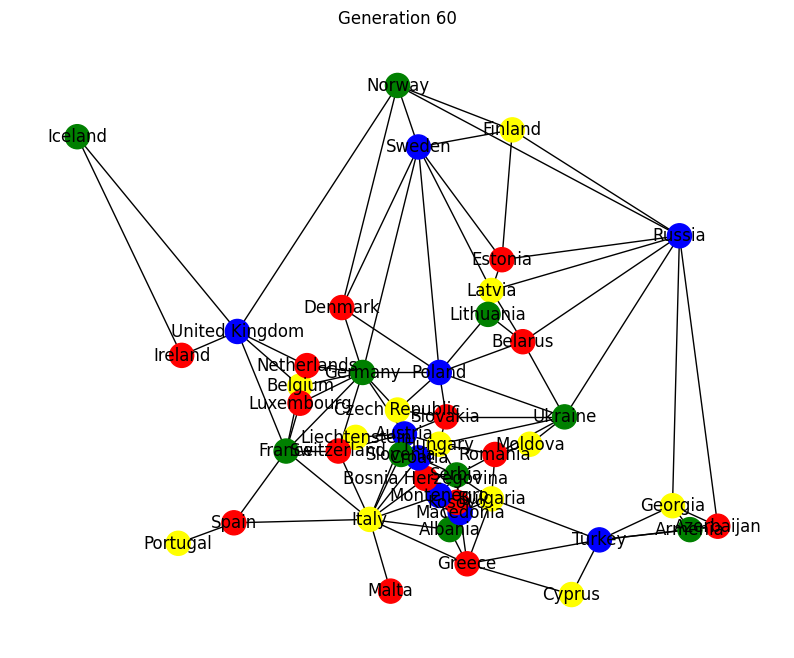

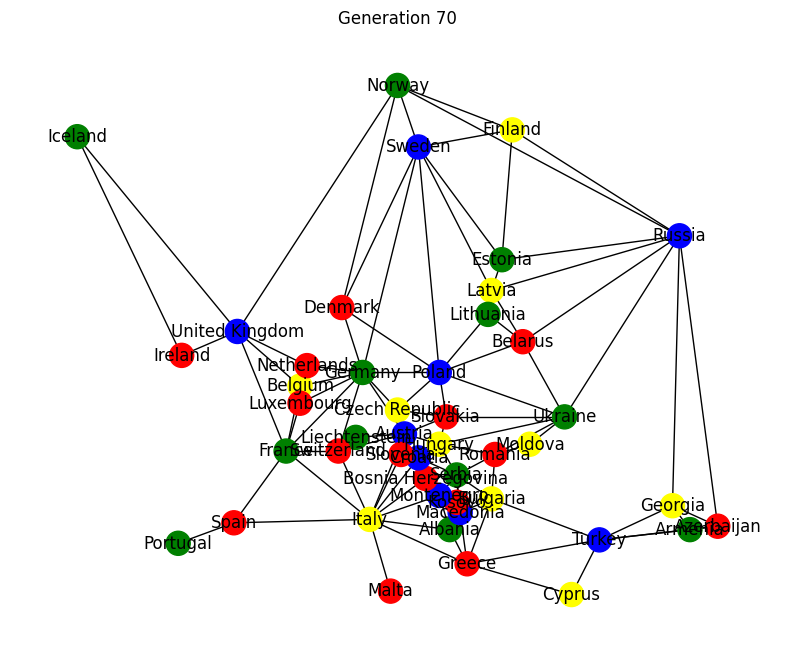

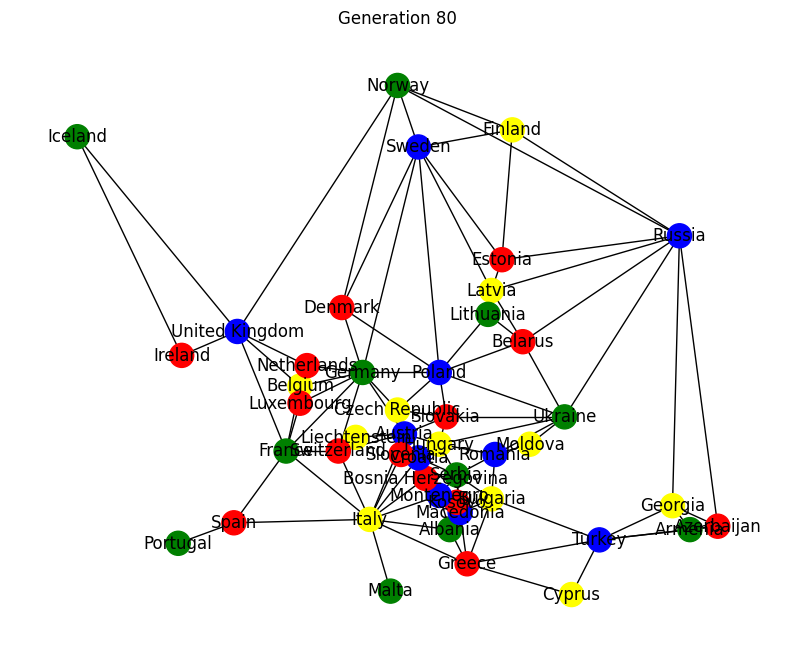

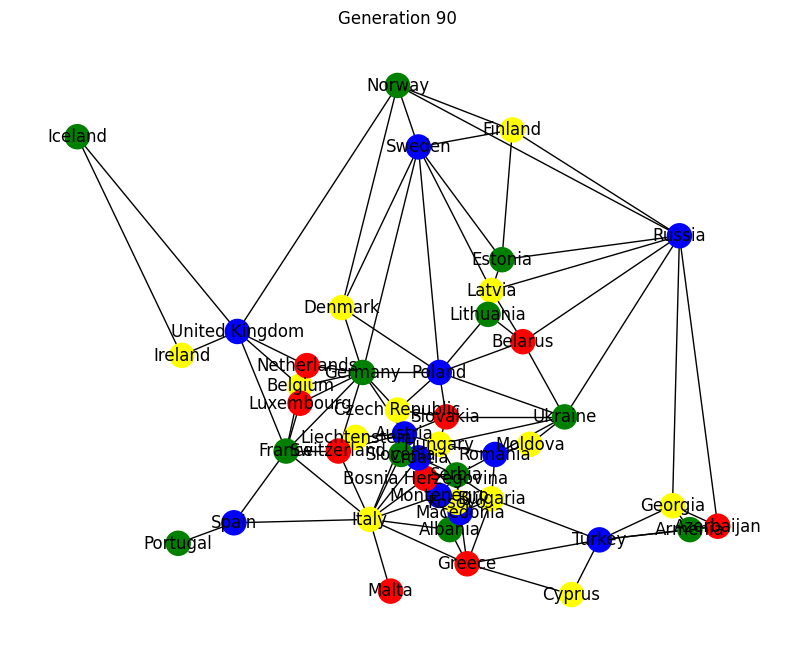

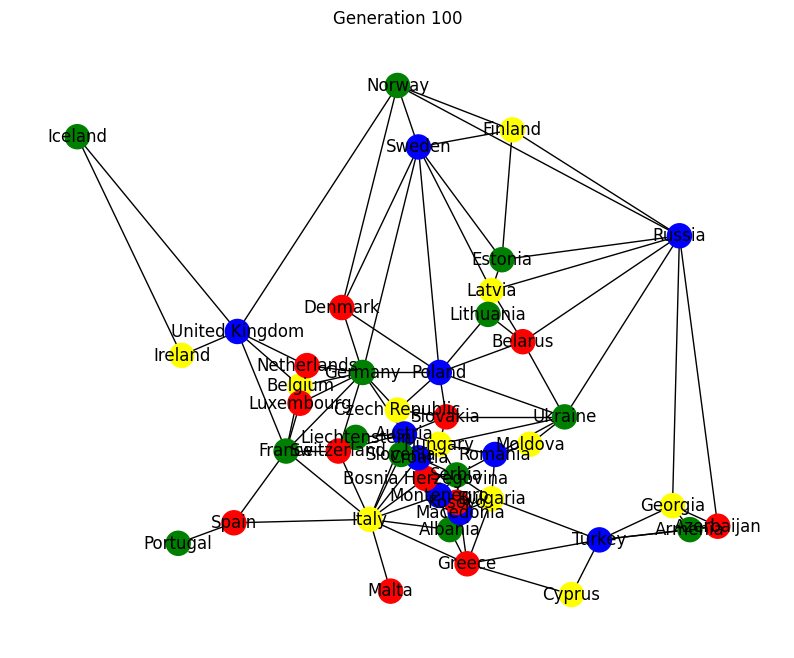

In [50]:
random.seed(0)
europe_solution = color_map_genetic(europe_graph, ["red", "blue", "green", "yellow"], hyperparameters, trace=True) # Feel free to add parameters

In [ ]:
if europe_solution:
    test_coloring(europe_graph, europe_solution)

In [ ]:
if europe_solution:
    draw_map("Europe", europe_graph, (10, 8), europe_solution)

## Before You Submit...

00. Re-read the general instructions provided above, and
01. Hit "Kernel"->"Restart & Run All". The first cell that is run should show [1], the second should show [2], and so on...
02. Submit your notebook (as .ipynb, not PDF) using Gradescope, and
03.  Do not submit any other files.